# Statistical analysis in `nilearn`

In [1]:
import numpy as np
import pandas as pd

from nilearn.datasets import fetch_haxby

haxby_dataset = fetch_haxby(subjects=(2,), fetch_stimuli=True)
print(haxby_dataset.description)

# set TR in seconds, following information in the original paper
t_r = 2.5

[fetch_haxby] Dataset found in /Users/emdupre/nilearn_data/haxby2001
.. _haxby_dataset:

Haxby dataset

Access
------
See :func:`nilearn.datasets.fetch_haxby`.

Notes
-----
Results from a classical :term:`fMRI` study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

See :footcite:t:`Haxby2001`.

Content
-------
The "simple" dataset includes:
    :'func': Nifti images with bold data
    :'session_target': Text file containing run data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels

The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with h

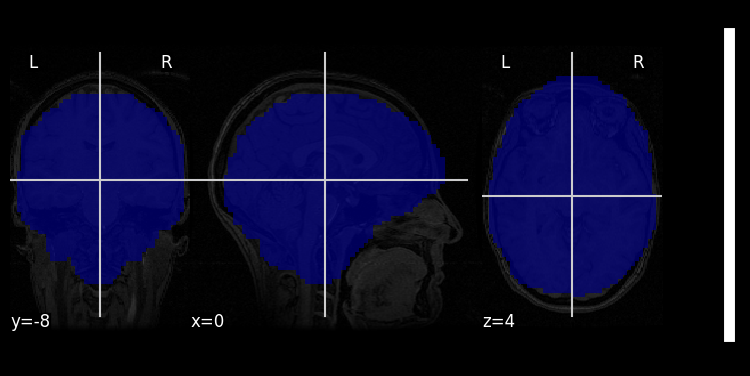

In [2]:
from nilearn import plotting

plotting.plot_roi(haxby_dataset.mask, bg_img=haxby_dataset.anat[0])

There are 1452 TRs in the file /Users/emdupre/nilearn_data/haxby2001/subj2/bold.nii.gz


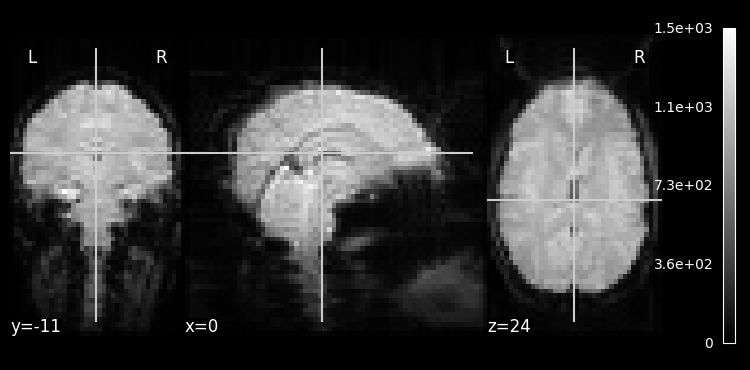

In [3]:
import nibabel as nib
from nilearn import image

mean_img_ = image.mean_img(haxby_dataset.func[0], copy_header=True)
plotting.plot_epi(mean_img_)

n_trs = nib.load(haxby_dataset.func[0]).shape[-1]
print(f"There are {n_trs} TRs in the file {haxby_dataset.func[0]}")

In [4]:
key_stimuli = []
exp_stimuli = []
for key, values in haxby_dataset.stimuli.items():
    key_stimuli.append(key)

    try:
        exp_stimuli.append(values[0])
    except KeyError:
        exp_stimuli.append(values['scrambled_faces'][0])

# update naming convention of 'controls' to match labels in behavioral csv
key_stimuli[3] = 'scrambledpix' 
print(key_stimuli)

['cats', 'houses', 'bottles', 'scrambledpix', 'chairs', 'scissors', 'shoes', 'faces']


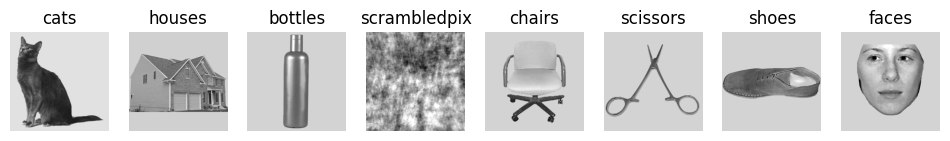

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))
# fig.suptitle("Example stimuli used in the experiment")

for img_path, img_categ, ax in zip(exp_stimuli, key_stimuli, axes.ravel()):
    ax.imshow(plt.imread(img_path), cmap="gray")
    ax.set_title(img_categ)

for ax in axes.ravel():
    ax.axis("off")

In [6]:
# Load target information as string 
events = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
events

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


In [7]:
unique_conditions = events["labels"].unique()
conditions = events["labels"].values

In [8]:
# Record these as an array of runs
runs = events["chunks"].to_numpy()
unique_runs = events["chunks"].unique()
print(unique_runs)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [9]:
# events will take the form of a dictionary of Dataframes, one per run
events = {}

for run in unique_runs:

    # get the condition label per run
    conditions_run = conditions[runs == run]

    # get the number of scans per run, then the corresponding
    # vector of frame times
    n_scans = len(conditions_run)
    frame_times = t_r * np.arange(n_scans)

    # each event last the full TR
    duration = t_r * np.ones(n_scans)

    # Define the events object
    events_ = pd.DataFrame(
        {
            "onset": frame_times,
            "trial_type": conditions_run,
            "duration": duration,
        }
    )
    # remove the rest condition and insert into the dictionary
    # this will be our baseline in the GLM, so we don't want to model it as a condition
    events[run] = events_[events_.trial_type != "rest"]

In [10]:
events[0]

,onset,trial_type,duration
6,15.0,scissors,2.5
7,17.5,scissors,2.5
8,20.0,scissors,2.5
9,22.5,scissors,2.5
10,25.0,scissors,2.5
...,...,...,...
110,275.0,chair,2.5
111,277.5,chair,2.5
112,280.0,chair,2.5
113,282.5,chair,2.5


In [11]:
from nilearn.glm.first_level import FirstLevelModel

z_maps = []
conditions_label = []
run_label = []

# Instantiate the glm
glm = FirstLevelModel(
    t_r=t_r,
    mask_img=haxby_dataset.mask,
    high_pass=0.008,
    smoothing_fwhm=4,
)

In [12]:
from nilearn.image import index_img

for run in unique_runs:
    # grab the fmri data for that particular run
    fmri_run = index_img(haxby_dataset.func[0], runs == run)

    # fit the GLM
    glm.fit(fmri_run, events=events[run])

    # set up contrasts: one per condition
    conditions = events[run].trial_type.unique()
    for condition_ in conditions:
        z_maps.append(glm.compute_contrast(condition_))
        conditions_label.append(condition_)
        run_label.append(run)

/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_9660/3071313550.py:8: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_9660/3071313550.py:8: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_9660/3071313550.py:8: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_9660/3071313550.py:8: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a 


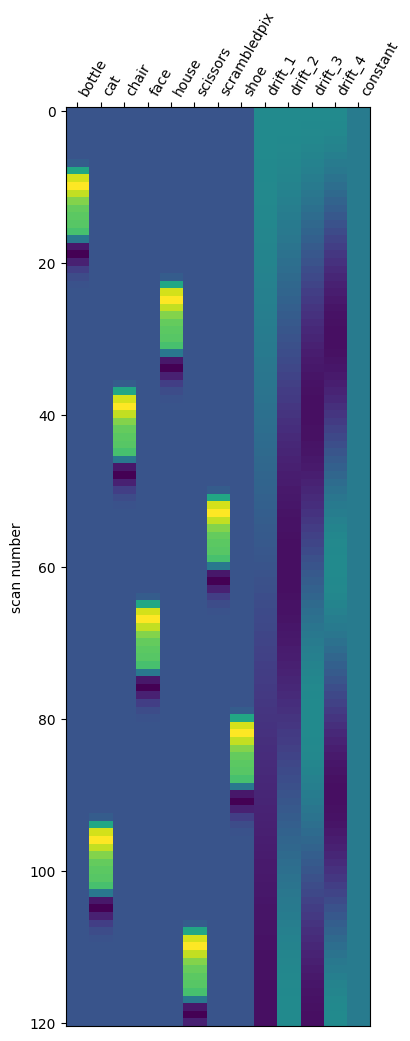
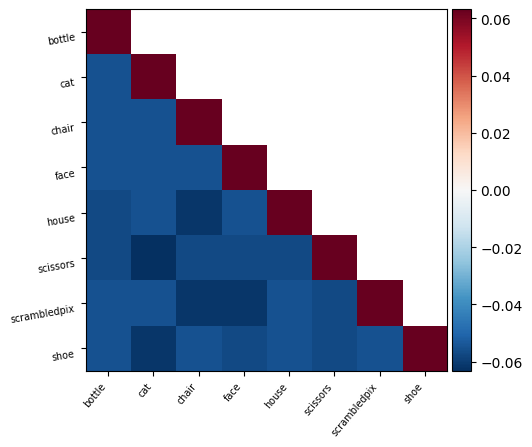
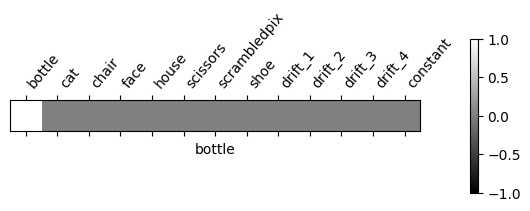
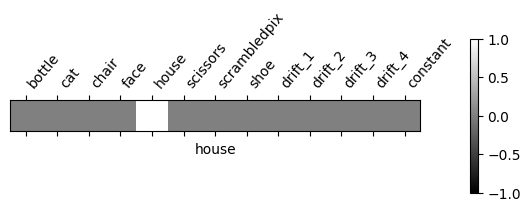
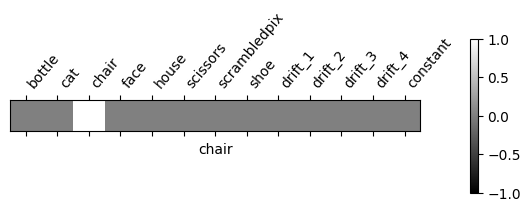
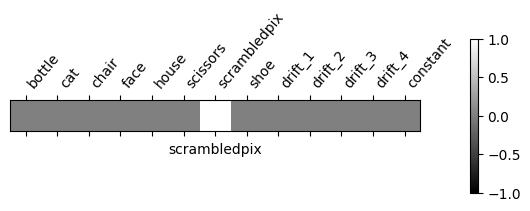
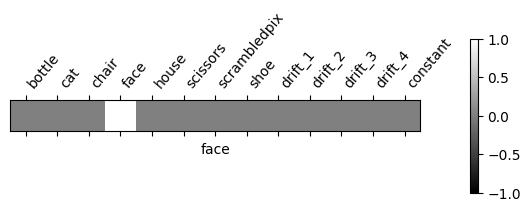
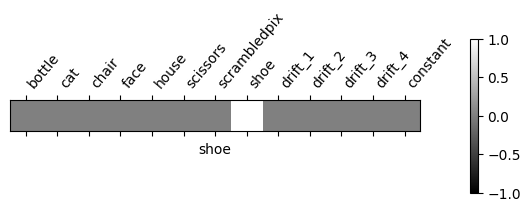
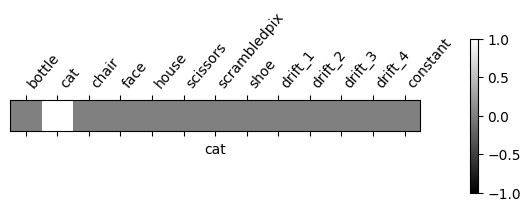
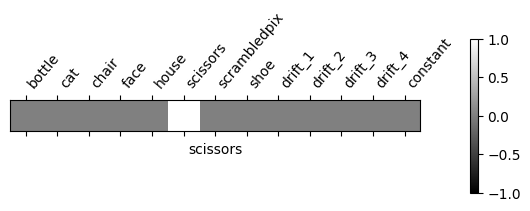
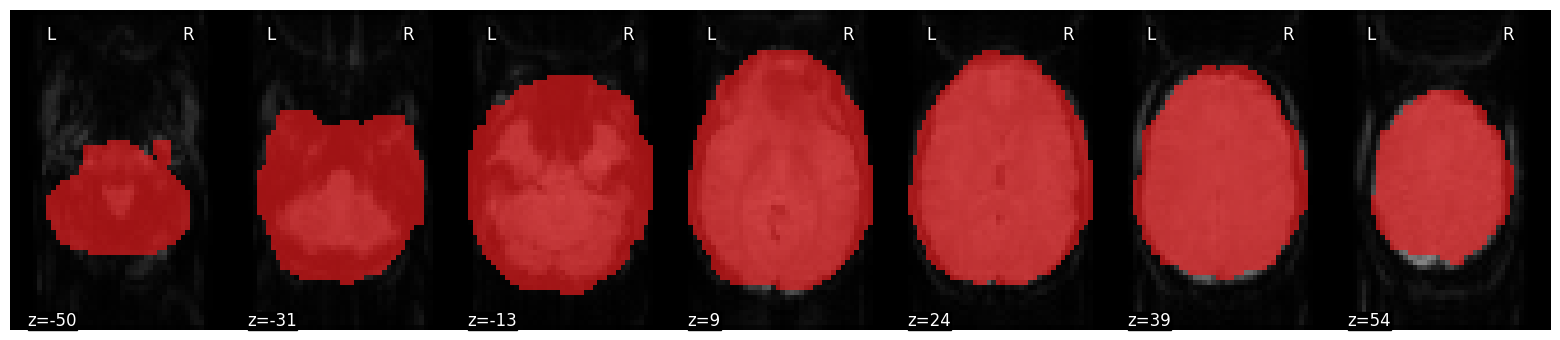
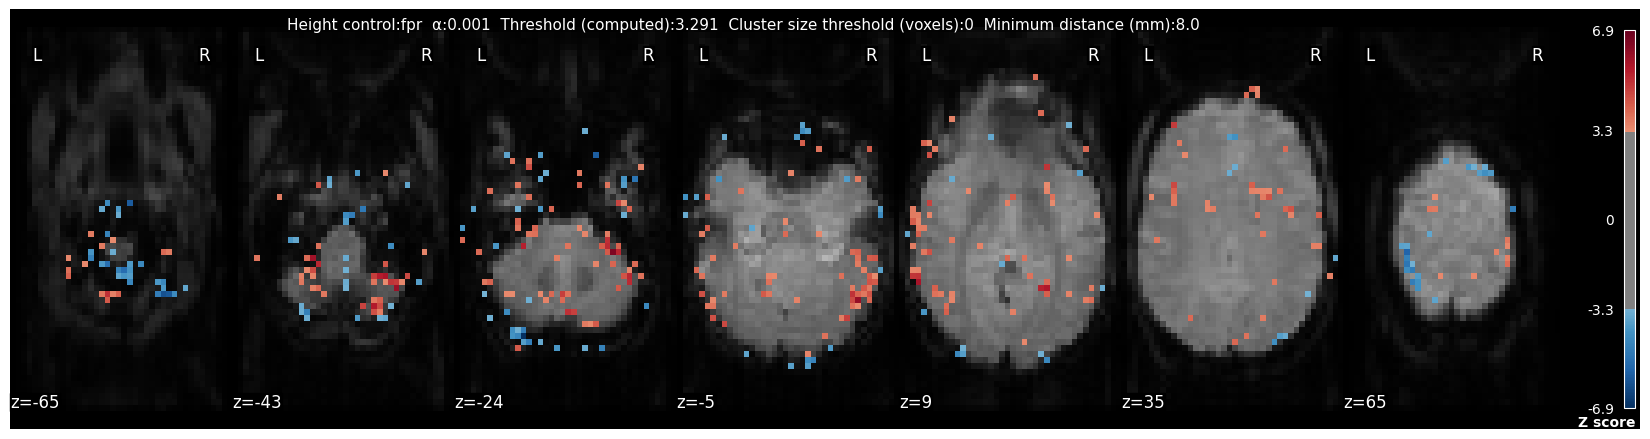
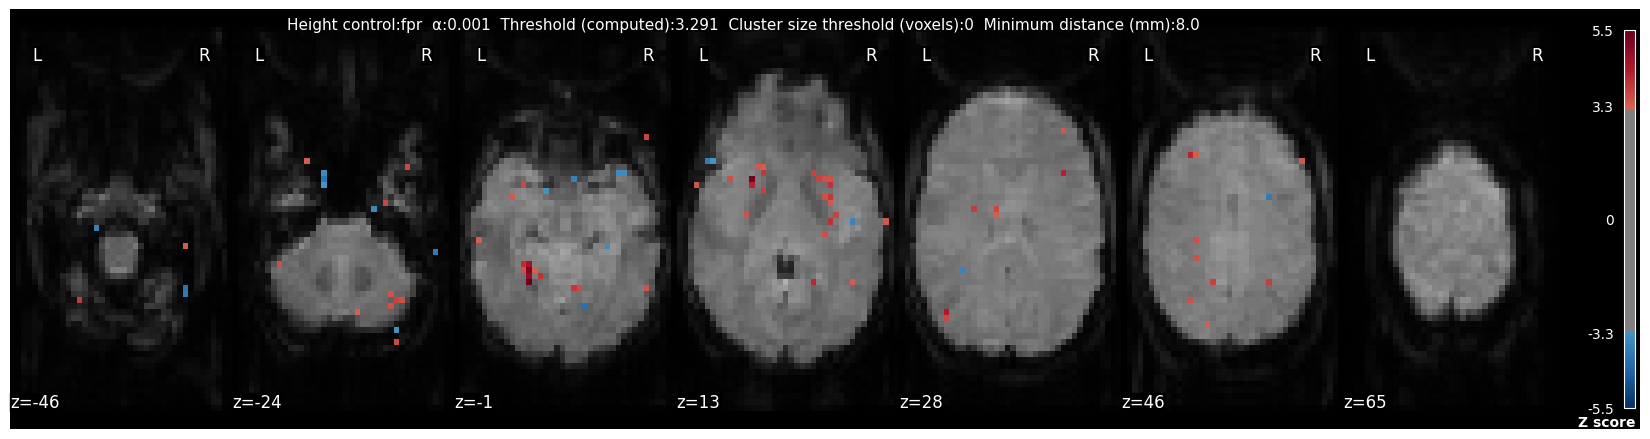
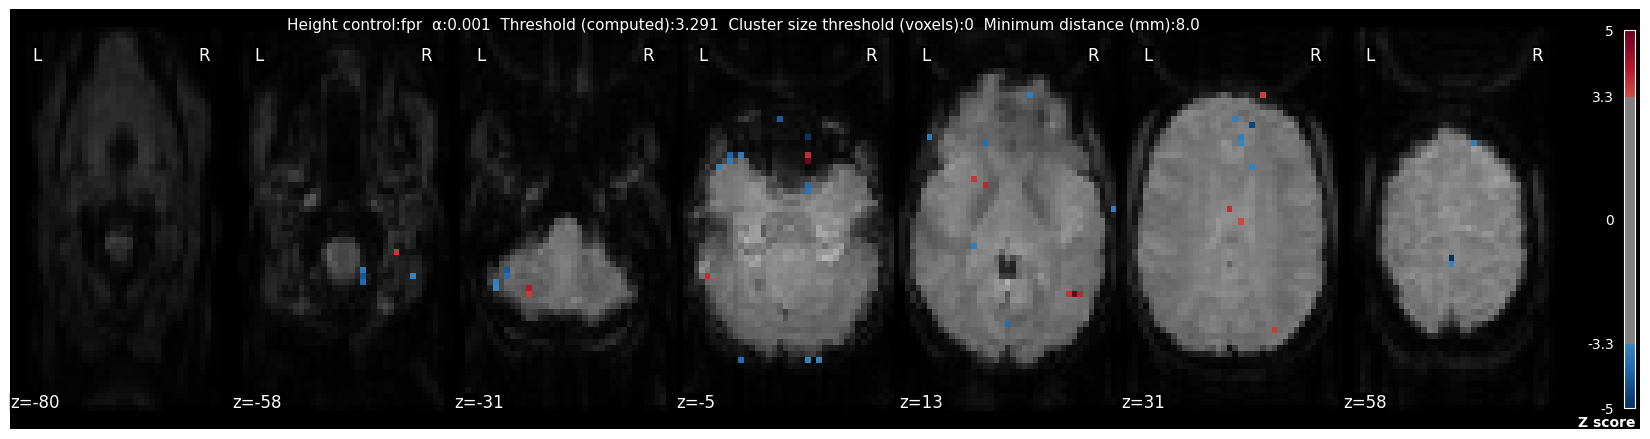
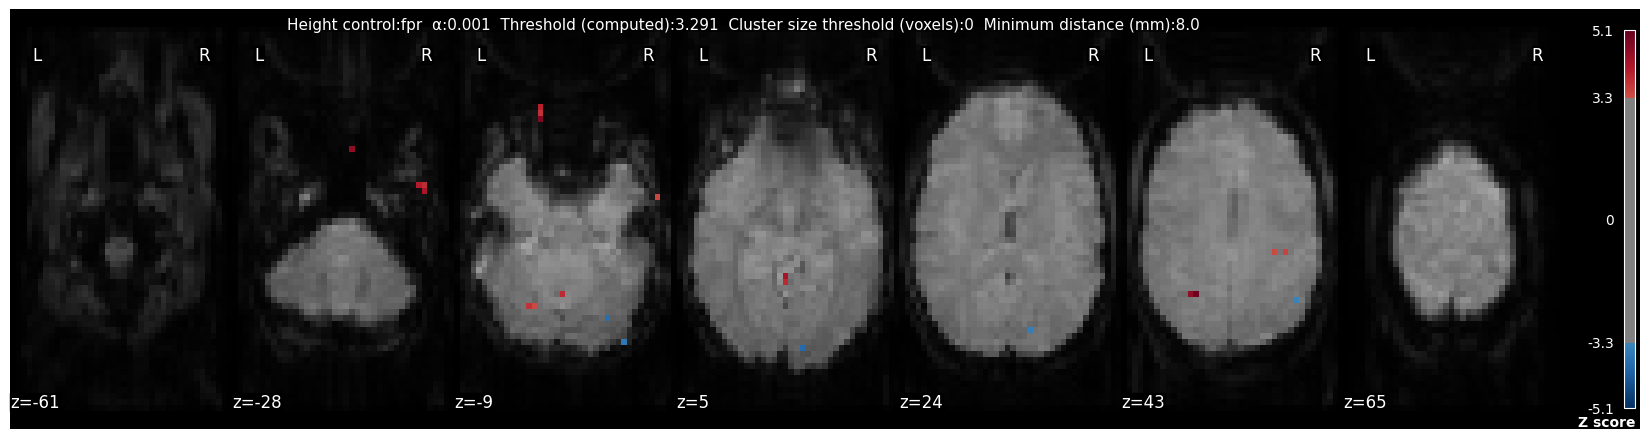
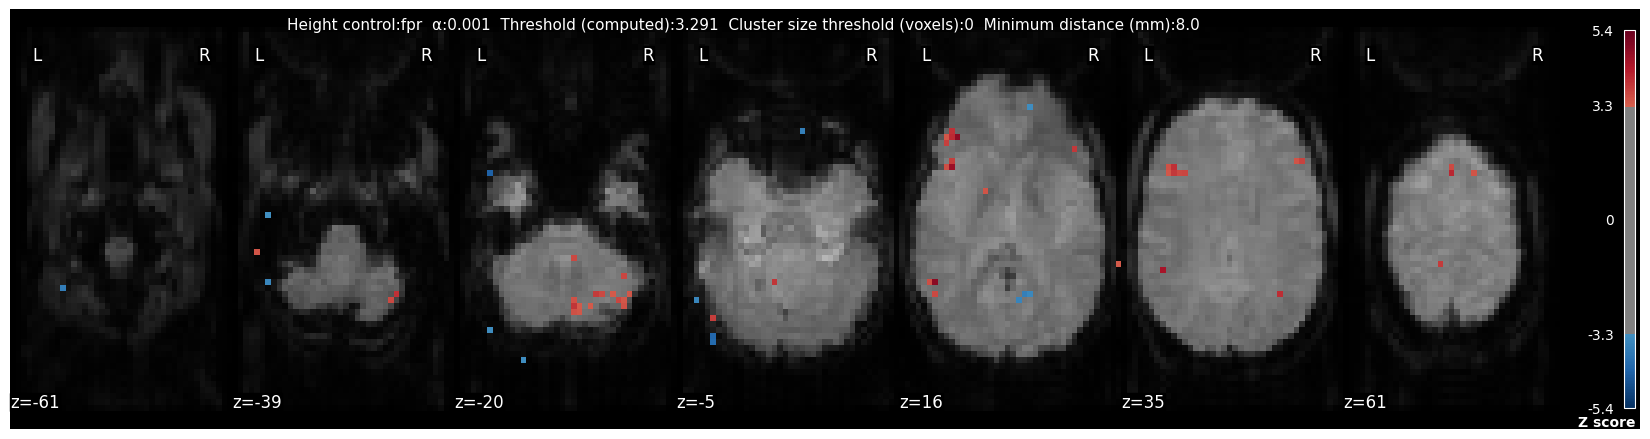
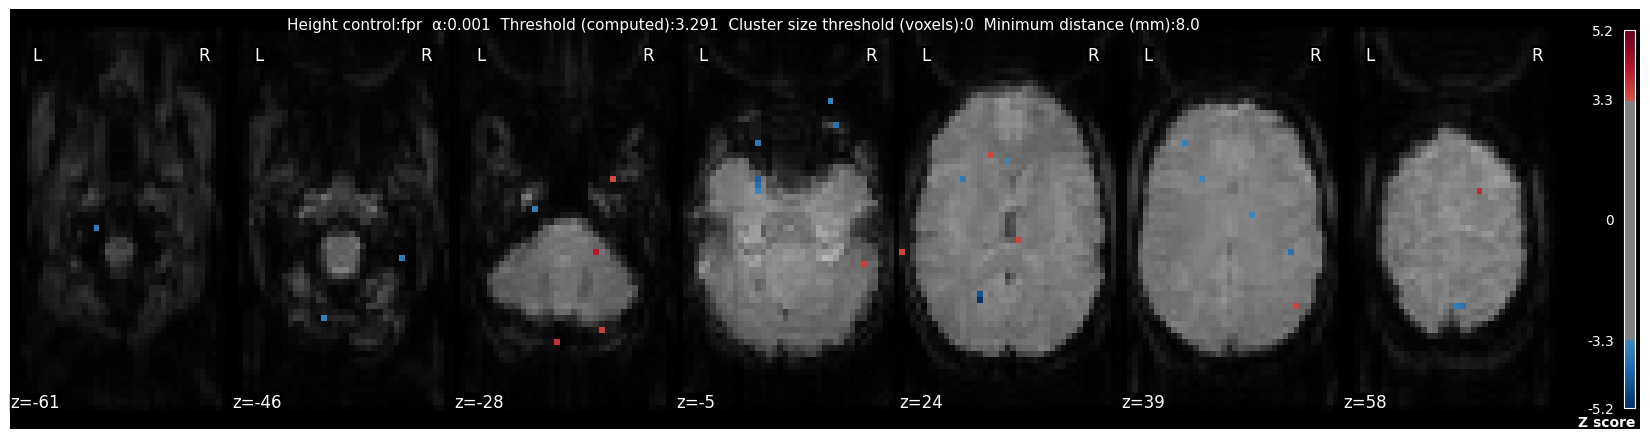
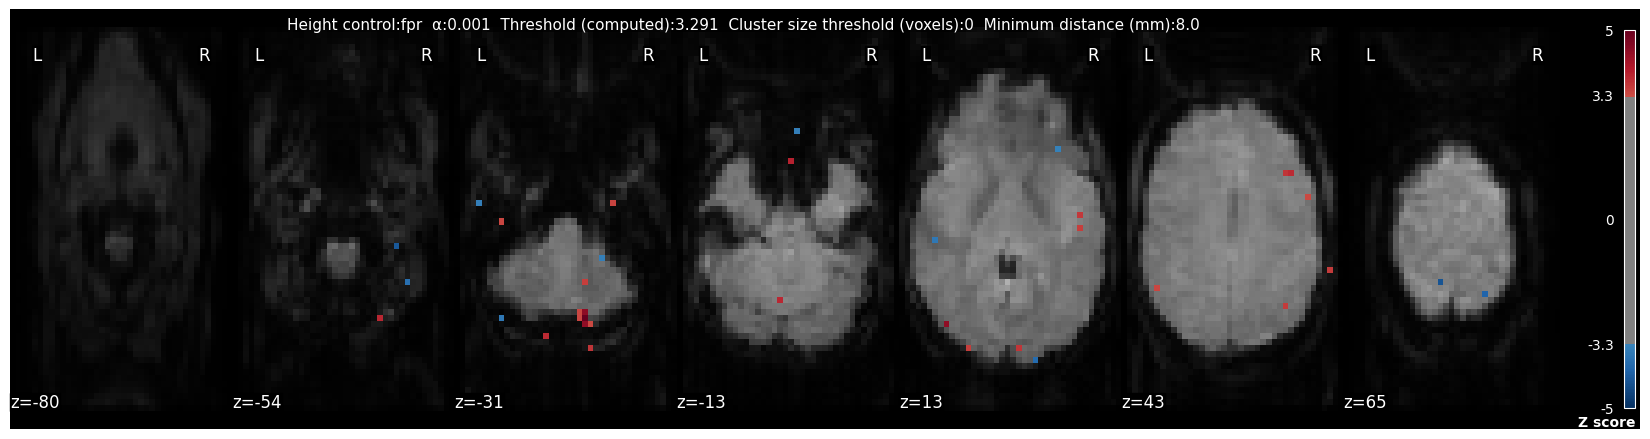
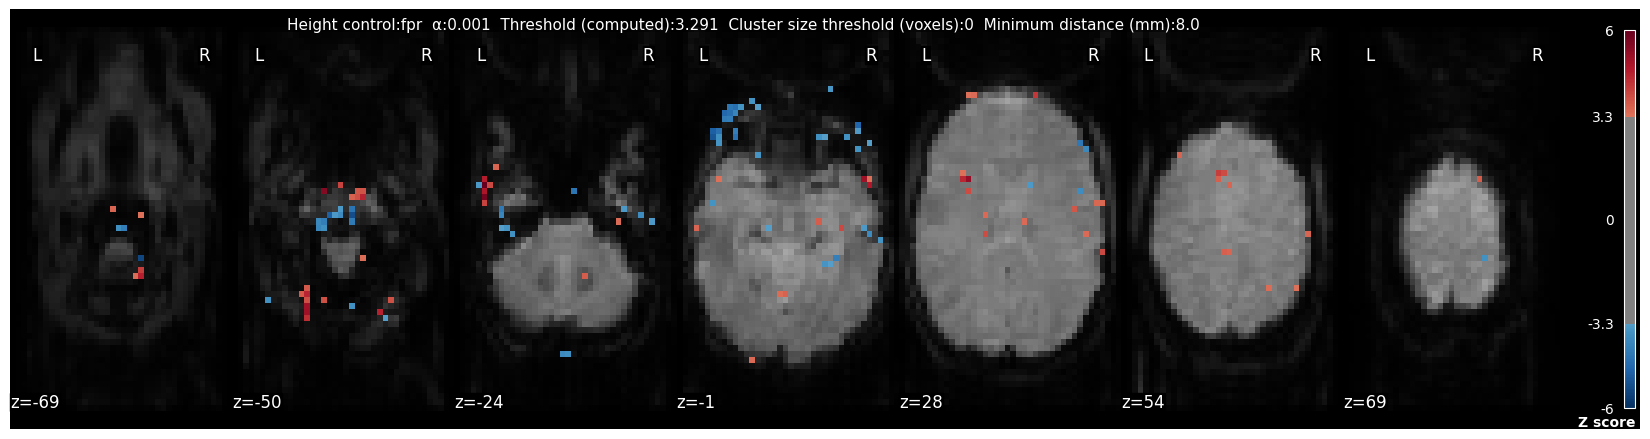

In [15]:
report = glm.generate_report(
    contrasts=conditions,
    bg_img=mean_img_,
)
report